In [43]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym
from gym.vector import SyncVectorEnv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import PIL
from PIL import Image
from IPython.core.display import clear_output

print(Image.__file__)

/home/lharms/.local/lib/python3.10/site-packages/PIL/Image.py


/tmp/ipykernel_136875/1252695180.py:15: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import clear_output


## Actor Critic

In [44]:
class ActorCritic(nn.Module):
    def __init__(self, action_dim):
        super(ActorCritic, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.actor = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )

    def extract_features(self, state):
        return self.cnn(state)

    def act(self, state):  # state: (B, C, H, W)
        with torch.no_grad():
            features = self.extract_features(state)              # (B, feature_dim)
            probs = self.actor(features)                         # (B, action_dim)
            dist = Categorical(probs)
            actions = dist.sample()                              # (B,)
            log_probs = dist.log_prob(actions)                   # (B,)
            entropy = dist.entropy()
            return actions, log_probs, entropy

    def evaluate(self, states, actions):
        features = self.extract_features(states)
        probs = self.actor(features)
        dist = Categorical(probs)
        log_probs = dist.log_prob(actions)
        entropy = dist.entropy()
        values = self.critic(features).squeeze(-1)
        return log_probs, entropy, values

#### A2C

In [45]:
class A2C:
    def __init__(self, action_dim, lr_actor, lr_critic, gamma):
        self.policy = ActorCritic(action_dim).to('cpu')
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])
        self.gamma = gamma

    def select_action(self, state):
        state_tensor = state.to("cpu") if isinstance(state, torch.Tensor) else torch.FloatTensor(state).to("cpu")
        return self.policy.act(state_tensor)

    def compute_returns(self, rewards, dones, last_value):
        R = last_value
        returns = []
        for reward, done in zip(reversed(rewards), reversed(dones)):
            if done:
                R = 0
            R = reward + self.gamma * R
            returns.insert(0, R)
        return returns

    def update_parallel(self, states, actions, log_probs, rewards, dones, next_state_batch, entropies):
        # Bootstrapping:
        with torch.no_grad():
            final_tensor = torch.FloatTensor(next_state_batch)
            final_value = self.policy.critic(self.policy.extract_features(final_tensor)).squeeze(-1)

        returns = []
        R = final_value
        for step in reversed(range(len(rewards))):
            R = rewards[step] + self.gamma * R * (1 - dones[step])
            returns.insert(0, R)

        returns = torch.stack(returns).detach()  # (n_steps, num_envs)
        log_probs = torch.stack(log_probs)
        actions = torch.stack(actions)

        states = torch.cat(states, dim=0)
        returns = returns.view(-1)
        actions = actions.view(-1)
        log_probs = log_probs.view(-1)
        entropies = torch.stack(entropies)  # list of Tensors → (n_steps, num_envs)
        entropy = entropies.view(-1)

        # critic value
        values = self.policy.critic(self.policy.extract_features(states)).squeeze(-1)

        advantages = returns - values.detach()
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        actor_loss = - (log_probs * advantages).mean()
        critic_loss = torch.nn.functional.mse_loss(values, returns)

        loss = actor_loss + 0.5 * critic_loss  - 0.1 * entropy.mean()

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
        self.optimizer.step()


#### environment

In [46]:
def make_env():
    def _thunk():
        env = gym_super_mario_bros.make('SuperMarioBros-v1')
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        env = SkipFrame(env, skip=frameskip)
        env = DeadlockEnv(env, threshold=(60 * 2) // frameskip)
        return env
    return _thunk

#This environment wrapper is used to stop a run if mario is stuck on a pipe
class DeadlockEnv(gym.Wrapper):
    def __init__(self, env, threshold=100):
        super().__init__(env)
        self.last_x_pos = 0
        self.last_y_pos = 0
        self.count = 0
        self.threshold = threshold
        self.lifes = 3
        self.stage = 1
        self.world = 1
        self.last_coins = 0
        self.max_y = float('inf')

        self.start_xpos = None

    def reset(self, **kwargs):
        self.last_x_pos = 0
        self.last_y_pos = 0
        self.count = 0
        self.start_xpos = None
        self.lifes = 3
        self.stage = 1
        self.world = 1
        self.last_coins = 0
        self.max_y = float('inf')

        return self.env.reset(**kwargs)

    def step(self, action):
        state, reward, done, info = self.env.step(action)

        x_pos = info['x_pos']
        y_pos = info['y_pos']

        if self.start_xpos is None:
            self.start_xpos = x_pos

        if x_pos <= self.last_x_pos:
            self.count += 1
        else:
            self.count = 0

        if info['life'] != self.lifes or info["stage"] != self.stage or info["world"] != self.world:
            self.last_x_pos = x_pos
            self.count = 0
            self.lifes = info['life']
            self.stage = info["stage"]
            self.world = info["world"]

        # coin bonus:
        coins_delta = info['coins'] - self.last_coins
        reward += min(coins_delta * 0.05, 2.0)
        self.last_coins = info['coins']

        # flag bonus:
        if info.get("flag_get", False):
            reward += 50
            done = True

        # forward movement:
        delta_x = x_pos - self.last_x_pos
        if delta_x > 0:
            reward += min(delta_x * 0.1, 5.0)
        #else:
         #   reward -= 0.01

        self.last_x_pos = x_pos

        # Survival bonus:
        if self.count % 30 == 0 and self.count != 0:
            reward += 0.5

        # Jumping bonus:
        if y_pos is not None:
            if not hasattr(self, 'last_y_pos'):
                self.last_y_pos = y_pos
                self.max_y = y_pos

            delta_y = self.last_y_pos - y_pos

            if y_pos < self.max_y:
                self.max_y = y_pos

            if delta_y > 0:
                reward += min(delta_y * 0.05, 1.0)

            if delta_y > 10 and delta_x > 5:
                reward += min((delta_y + delta_x) * 0.02, 2.5)

            if delta_y > 5 and delta_x < 2:
                reward -= 0.05

            if y_pos >= self.last_y_pos:
                self.max_y = y_pos

            self.last_y_pos = y_pos

        if self.count >= self.threshold:
            reward = -5
            done = True

        # Distance Tracking
        distance = x_pos - self.start_xpos
        info['distance'] = distance

        return state, reward, done, info


#skipframe wrapper
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        reward_out = 0
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            reward_out += reward
            if done:
                break
        reward_out /= max(1,i+1)

        return obs, reward_out, done, info

#downsample wrapper to reduce dimensionality
def Downsample(ratio,state):
  (oldh, oldw, oldc) = state.shape
  newshape = (oldh//ratio, oldw//ratio, oldc)
  frame = cv2.resize(state, (newshape[0], newshape[1]), interpolation=cv2.INTER_AREA)
  return frame

#small function to change rgb images to grayscale
def GrayScale(state):
  return cv2.cvtColor(state, cv2.COLOR_RGB2GRAY)


#### Training


=== EPOCH 1 SUMMARY ===
avg_reward: [0]
avg_length: [0]
avg_distance: [0]
avg_coins: [0]
Epoch 1 | Avg Reward: 0.00 | Avg Length: 0.0

=== EPOCH 2 SUMMARY ===
avg_reward: [0, 0]
avg_length: [0, 0]
avg_distance: [0, 0]
avg_coins: [0, 0]
Epoch 2 | Avg Reward: 0.00 | Avg Length: 0.0
Env 3 done! Reward: 280.2966666666666, Length: 139, Distance: 258
[DEBUG] x_pos: 298 | coins: 1 | flags: [False False False False False False False False]

=== EPOCH 3 SUMMARY ===
avg_reward: [0, 0, 280.2966666666666]
avg_length: [0, 0, 139.0]
avg_distance: [0, 0, 0]
avg_coins: [0, 0, 0]
Epoch 3 | Avg Reward: 280.30 | Avg Length: 139.0

=== EPOCH 4 SUMMARY ===
avg_reward: [0, 0, 280.2966666666666, 280.2966666666666]
avg_length: [0, 0, 139.0, 139.0]
avg_distance: [0, 0, 0, 0]
avg_coins: [0, 0, 0, 0]
Epoch 4 | Avg Reward: 280.30 | Avg Length: 139.0

=== EPOCH 5 SUMMARY ===
avg_reward: [0, 0, 280.2966666666666, 280.2966666666666, 280.2966666666666]
avg_length: [0, 0, 139.0, 139.0, 139.0]
avg_distance: [0, 0, 0, 

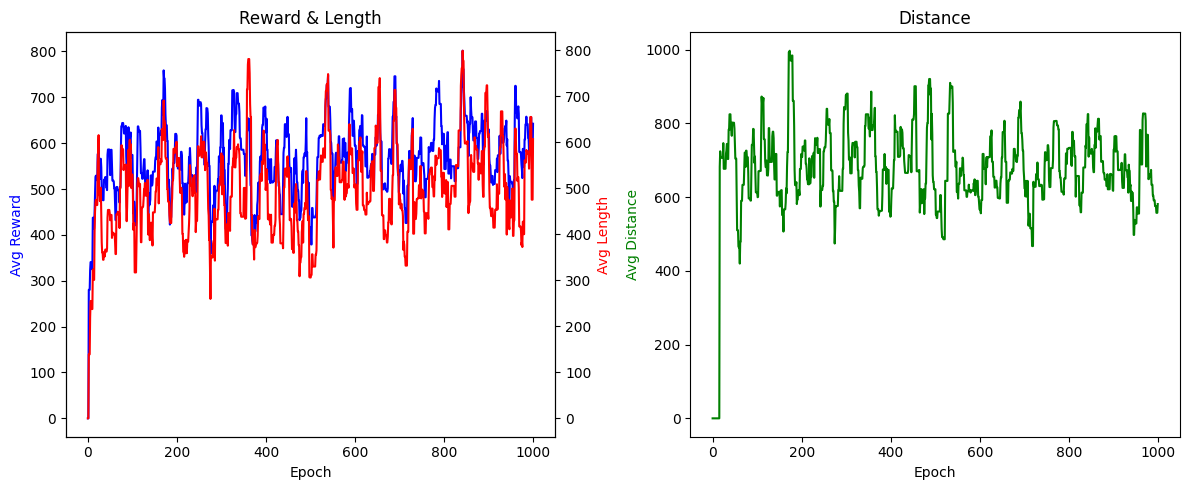

===== Results =====
Avg Reward: 565.74 | Avg Length: 494.20 | Avg Distance: 673.60 | Avg Coins: 1.08
Highest Reward: 0 | Highest Length: 1773 | Highest Distance: 857


In [48]:
# hyperparameters:
frameskip = 4
down_sample_rate = 4
lr_actor = 1e-4 #  0.0003 -> 1e-4 -> 2.5e-5 -> 1e-4
lr_critic = 5e-4 # 0.001 -> 5e-4 -> 2.55e-4 -> 5e-4
gamma = 0.995
frame_stack = 4
num_envs = 8
n_steps = 50
max_epochs = 1000
window_size = 10
video_env_id = 0

episode_rewards = [0.0 for _ in range(num_envs)]
episode_lengths = [0 for _ in range(num_envs)]

# Für Statistik
rewards_log = []
lengths_log = []
distance_log = []
coins_log = []
flag_log = []
avg_reward = []
avg_length = []
avg_distance = []
avg_coins = []

def make_env():
    def _thunk():
        env = gym_super_mario_bros.make('SuperMarioBros-v1')
        env = JoypadSpace(env, SIMPLE_MOVEMENT)
        env = SkipFrame(env, skip=frameskip)
        env = DeadlockEnv(env, threshold=(60 * 2) // frameskip)
        return env
    return _thunk

envs = SyncVectorEnv([make_env() for _ in range(num_envs)])
render_env = make_env()()

action_dim = envs.single_action_space.n

agent = A2C(action_dim=action_dim, lr_actor=lr_actor, lr_critic=lr_critic, gamma=gamma)

frame_buffers = [deque(maxlen=frame_stack) for _ in range(num_envs)]
obs = envs.reset()

# Preprocessing initial state
def preprocess(obs):
    processed = []
    for i in range(num_envs):
        img = GrayScale(Downsample(down_sample_rate, obs[i]))
        img = cv2.resize(img, (84, 84)) / 255.0
        for _ in range(frame_stack):
            frame_buffers[i].append(img)
        processed.append(np.stack(frame_buffers[i], axis=0))
    return np.stack(processed)

state_batch = preprocess(obs)

# ==== Training Loop ====
for epoch in range(max_epochs):
    all_states, all_actions, all_log_probs = [], [], []
    rewards_per_step, dones_per_step, entropy_per_step = [], [], []
    frames = []
    highest_length, highest_reward, highest_distance = 0, 0, 0
    avg_reward_epoch, avg_length_epoch, avg_distance_epoch, avg_coin_epoch = 0, 0, 0, 0

    for _ in range(n_steps):
        state_tensor = torch.FloatTensor(state_batch)  # (num_envs, 4, 84, 84)
        actions, log_probs, entropies = agent.select_action(state_tensor)

        obs, rewards, dones, info = envs.step(actions.numpy())

        # Für Statistik
        for i in range(num_envs):
            episode_rewards[i] += rewards[i]
            episode_lengths[i] += 1

            if dones[i]:
                if episode_lengths[i] > highest_length:
                    highest_length = episode_lengths[i]
                elif episode_rewards[i] > highest_reward:
                    highest_reward = episode_rewards[i]
                print(f"Env {i} done! Reward: {episode_rewards[i]}, Length: {episode_lengths[i]}, Distance: {info['distance'][i]}")
                print(f"[DEBUG] x_pos: {info['x_pos'][i]} | coins: {info['coins'][i]} | flags: {info.get('flag_get', False)}")
                rewards_log.append(episode_rewards[i])
                lengths_log.append(episode_lengths[i])
                distance_log.append(info['distance'][i])
                coins_log.append(info['coins'][i])
                episode_rewards[i] = 0.0
                episode_lengths[i] = 0
                if info['distance'][i] > highest_distance:
                    highest_distance = info['distance'][i]


        # nächster Zustand verarbeiten
        next_state_stack = []
        for i in range(num_envs):
            img = GrayScale(Downsample(down_sample_rate, obs[i]))
            img = cv2.resize(img, (84, 84)) / 255.0
            frame_buffers[i].append(img)
            stacked = np.stack(frame_buffers[i], axis=0)
            next_state_stack.append(stacked)
        state_batch = np.stack(next_state_stack)

        # Logging der Trainingsdaten
        all_states.append(state_tensor)
        all_actions.append(actions)
        all_log_probs.append(log_probs)
        rewards_per_step.append(torch.tensor(rewards, dtype=torch.float32))
        dones_per_step.append(torch.tensor(dones, dtype=torch.float32))
        entropy_per_step.append(entropies)


    # === Update ===
    agent.update_parallel(
        all_states, all_actions, all_log_probs,
        rewards_per_step, dones_per_step, state_batch,
        entropy_per_step
    )

    # statistic:
    if len(rewards_log) >= window_size:
        avg_reward_epoch = np.mean(rewards_log[-window_size:])
        avg_length_epoch = np.mean(lengths_log[-window_size:])
        avg_distance_epoch = np.mean(distance_log[-window_size:])
        avg_coin_epoch = np.mean(coins_log[-window_size:])
    elif rewards_log:
        avg_reward_epoch = np.mean(rewards_log)
        avg_length_epoch = np.mean(lengths_log)
    elif distance_log:
        avg_distance_epoch = np.mean(distance_log)
    elif coins_log:
        avg_coin_epoch = np.mean(coins_log)
    else:
        avg_reward_epoch = 0
        avg_length_epoch = 0
        avg_distance_epoch = 0
        avg_coin_epoch = 0

    avg_reward.append(avg_reward_epoch)
    avg_length.append(avg_length_epoch)
    avg_distance.append(avg_distance_epoch)
    avg_coins.append(avg_coin_epoch)

    print(f"\n=== EPOCH {epoch+1} SUMMARY ===")
    print("avg_reward:", avg_reward[-5:])
    print("avg_length:", avg_length[-5:])
    print("avg_distance:", avg_distance[-5:])
    print("avg_coins:", avg_coins[-5:])
    print(f"Epoch {epoch+1} | Avg Reward: {avg_reward_epoch:.2f} | Avg Length: {avg_length_epoch:.1f}")

    if epoch % 200 == 0:
        torch.save(agent.policy.state_dict(), f"../../runs/A2C/04_testA2C/19_reward/a2c_epoch_{epoch}.pt")

x = np.arange(len(avg_reward))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 Zeile, 2 Spalten

# Plot 1: Avg Reward & Avg Length
ax1_2 = ax1.twinx()
ax1.plot(x, avg_reward, 'b-', label='Avg Reward')
ax1_2.plot(x, avg_length, 'r-', label='Avg Length')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Avg Reward', color='b')
ax1_2.set_ylabel('Avg Length', color='r')
ax1.set_title("Reward & Length")

# Plot 2: Avg Distance
x = np.arange(len(avg_distance))
ax2.plot(x, avg_distance, 'g-', label='Avg Distance')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Avg Distance', color='g')
ax2.set_title("Distance")

plt.tight_layout()
plt.show()

print("===== Results =====")
print(f"Avg Reward: {np.mean(avg_reward):.2f} | Avg Length: {np.mean(avg_length):.2f} | Avg Distance: {np.mean(avg_distance):.2f} | Avg Coins: {np.mean(avg_coins):.2f}")
print(f"Highest Reward: {highest_reward} | Highest Length: {highest_length} | Highest Distance: {highest_distance}")